### Introduction

We have tweets which are classified into Positive, Negative and Neutral. We have to use this to solve a problem of our choice as long as it involves the pymc package. The first step is learn about the data and pymc.

In [149]:
import pymc as pm
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

### What information do we have?

Each row in the given data represents a tweet made by a user. airline_sentiment and negative_reason was labelled by appen.com. They ask several users to label reviews into sentiment categories. The most popular category chosen by the users is the final category. The variance is represented by airline_sentiment_confidence. High variance is caused by low sample size or a probability near 0.5. (See multinomial distribution variance)

- 'tweet_id'- unique tweet id
- 'airline_sentiment' - categorical sentiment. (label)
- 'airline_sentiment_confidence - certainty of labeling
- 'negativereason' - categorical negative reason. NaN if tweet is positive.(label)
- 'negativereason_confidence' - certainty of labeling
- 'airline' - name of airline
- 'airline_sentiment_gold' - ???
- 'name' - name of user.
- 'negativereason_gold' - ???
- 'retweet_count'- n retweets.
- 'text' - tweet text.
- 'tweet_coord' - gps coord
- 'tweet_created' - date
- 'tweet_location' - City
- 'user_timezone' - timezone

In [150]:
raw = pd.read_csv("Tweets.csv")

In [151]:
print(raw.head(2).to_string())

             tweet_id airline_sentiment  airline_sentiment_confidence negativereason  negativereason_confidence         airline airline_sentiment_gold      name negativereason_gold  retweet_count                                                                      text tweet_coord              tweet_created tweet_location               user_timezone
0  570306133677760513           neutral                        1.0000            NaN                        NaN  Virgin America                    NaN   cairdin                 NaN              0                                       @VirginAmerica What @dhepburn said.         NaN  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)
1  570301130888122368          positive                        0.3486            NaN                        0.0  Virgin America                    NaN  jnardino                 NaN              0  @VirginAmerica plus you've added commercials to the experience... tacky.         NaN  2015-02-24 11

In [152]:
raw.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [153]:
raw.user_timezone.unique() 
# Choose to ignore this

array(['Eastern Time (US & Canada)', 'Pacific Time (US & Canada)',
       'Central Time (US & Canada)', 'America/New_York',
       'Atlantic Time (Canada)', 'Quito', nan,
       'Mountain Time (US & Canada)', 'Vienna', 'Caracas', 'Kuala Lumpur',
       'Brisbane', 'Arizona', 'London', 'Tehran', 'Alaska', 'Sydney',
       'Irkutsk', 'Santiago', 'Amsterdam', 'Tijuana', 'Abu Dhabi',
       'Central America', 'Edinburgh', 'Jerusalem', 'Hawaii', 'Paris',
       'Guam', 'New Delhi', 'Stockholm', 'America/Chicago', 'Berlin',
       'Madrid', 'Athens', 'Brussels', 'Taipei', 'Rome', 'Beijing',
       'Mexico City', 'Bern', 'Singapore', 'Indiana (East)', 'Melbourne',
       'Saskatchewan', 'Casablanca', 'Brasilia', 'Kyiv', 'Bucharest',
       'Greenland', 'Prague', 'New Caledonia', 'Bogota', 'Seoul',
       'Sarajevo', 'Wellington', 'Bangkok', 'Warsaw', 'Copenhagen',
       'Hong Kong', 'Guadalajara', 'Mid-Atlantic', 'Mazatlan',
       'Buenos Aires', 'America/Los_Angeles', 'Dublin', 'Lisbon',
 

In [154]:
raw['tweet_coord'].count()*100/raw['tweet_coord'].isnull().sum() # percentage not missing

7.481095367447324

In [155]:
raw.groupby('negativereason')['negativereason'].count()

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
Name: negativereason, dtype: int64

In [156]:
# Range date
a = raw['tweet_created'].str[:19]
b = pd.to_datetime(a)
b.describe()
# Therefore, we only have 1 week of information.

count                            14640
mean        2015-02-21 11:33:24.781216
min                2015-02-16 23:36:05
25%      2015-02-19 15:54:05.750000128
50%         2015-02-22 04:44:35.500000
75%                2015-02-23 08:04:11
max                2015-02-24 11:53:37
Name: tweet_created, dtype: object

### What is PYMC?
Performs Bayesian inference using computational methods. i.e. Finds Posterior given prior.Since I only have a few hours to implement a solution using pymc, I will stick to a simple GLM regression. Regression allows one to:
1. Predict Y from X
2. Obtain a linear relationship. (how much of Y can I get for each X)
3. Does Y depend on X1? i.e. X1 = day of the month? day of the week? etc...
4. Error bars for each Beta 1, Beta 2 etc...

### Proposed Solution
Company A provides customer support for airlines, travel agencies. **They want to hire more staff when the urgent complaints/hour are at the highest.** This makes sure that the waiting times are low throughout the day, while minimising costs. 
- Example of urgent complaints: Cancelled Flight, Lost Luggage, Flight Booking Problems, Damaged Luggage. 

Given 1 week of data, we want to know what next week will look like, and suggest when to hire people. We assume that:
1. The underlying distribution of complaints for this week is the same as next week. (This is a big approximation, but generally good)
2. Twitter Complaints will match Customer calls complaints (Another big assumption)

Model Variables:

- Y : Number of Urgent Complaints in 1 hour (Poisson, Log link function)
- X1 : Time of Day Dummies. 
- X2 : Day of Week Dummies. 
- X3 : Interaction Variables between Day and Time. (Didnt do - no time)
- X4 : Airline Dummies (Didnt do - no time)

Cross Validation will be skipped due to lack of time. But also Linear models are almost immune to overfitting.

### Transform Input Data
Convert tweet level table to an hourly datetime table. 
- Input schema: tweet i, datetime i, negative reason i, airline i
- Output schema : hour i, date i, airline i, is_urgent_flag i

In [157]:
# Cleaning
df_raw = raw.copy()
df_raw = df_raw[['negativereason', 'tweet_created', 'airline']]
print(df_raw.isnull().sum()/len(df_raw))
df_raw.dropna(inplace = True)

negativereason    0.373087
tweet_created     0.000000
airline           0.000000
dtype: float64


In [158]:
# For a linear model we dont need 15000 rows, so 40% of misssing data can be deleted.
# Imputation would add bias of unknown size.
print(df_raw.isnull().sum()/len(df_raw))

negativereason    0.0
tweet_created     0.0
airline           0.0
dtype: float64


In [159]:
# Convert negative reason to is_urgent_flag
df_raw['negativereason'] = df_raw['negativereason'].apply(lambda x: x.strip())
df_raw['is_urgent_flag'] =\
    df_raw['negativereason'].str.contains(
    r'Cancelled Flight|Lost Luggage|Flight Booking Problems|Damaged Luggage') * 1

In [160]:
# Airline categorical data is fine. One hot later
df_raw.groupby('airline')['is_urgent_flag'].sum()

airline
American          537
Delta             163
Southwest         327
US Airways        476
United            616
Virgin America     55
Name: is_urgent_flag, dtype: int32

In [161]:
# Separate Date into day_of_week(1-7) and hour_of_day(0-24)

df_raw['tweet_created_dt'] = pd.to_datetime(df_raw['tweet_created'].str[:19]) # reformat to dt
df_raw['day_of_week'] = df_raw['tweet_created_dt'].dt.day_of_week
df_raw['is_weekend'] = (df_raw['tweet_created_dt'].dt.day_of_week >= 5) * 1
df_raw['hour'] = df_raw['tweet_created_dt'].dt.hour
# df_raw['tweet_created_d'] = df_raw['tweet_created_dt'].dt.date

df_raw.head()

,negativereason,tweet_created,airline,is_urgent_flag,tweet_created_dt,day_of_week,is_weekend,hour
3,Bad Flight,2015-02-24 11:15:36 -0800,Virgin America,0,2015-02-24 11:15:36,1,0,11
4,Can't Tell,2015-02-24 11:14:45 -0800,Virgin America,0,2015-02-24 11:14:45,1,0,11
5,Can't Tell,2015-02-24 11:14:33 -0800,Virgin America,0,2015-02-24 11:14:33,1,0,11
15,Late Flight,2015-02-24 10:01:50 -0800,Virgin America,0,2015-02-24 10:01:50,1,0,10
17,Bad Flight,2015-02-24 09:39:46 -0800,Virgin America,0,2015-02-24 09:39:46,1,0,9


In [181]:
df_raw = df_raw[['is_urgent_flag', 'day_of_week', 'is_weekend', 'hour', 'airline']]
# Y = B_1*dow + B_2*is_weekend + B_3*hour + B_4*airline

In [182]:
df_clean = df_raw.groupby(by = ['day_of_week','hour','is_weekend', 'airline'])['is_urgent_flag'].sum()
df_clean= df_clean.to_frame().rename(columns={'is_urgent_flag':'n_urgent'}).reset_index()
df_clean

,day_of_week,hour,is_weekend,airline,n_urgent
0,0,0,0,American,4
1,0,0,0,Southwest,0
2,0,0,0,US Airways,0
3,0,0,0,United,3
4,0,1,0,American,7
...,...,...,...,...,...
743,6,22,1,Virgin America,1
744,6,23,1,American,9
745,6,23,1,Delta,0
746,6,23,1,US Airways,2


### Feature Engineering

Transform cleaned data to make linear regression more effective.

1. Airline - onehotencoding
2. day_of_week and hour - angular distance (https://mikulskibartosz.name/time-in-machine-learning)
    - Angular distance captures the periodic nature of days and hours.
    - onehot encoding would ignore the face that sunday is close to monday and saturday
3. is_weekend - no change necessary

In [183]:
# angular distance
df_clean['day_of_week_sin'] = np.sin(df_clean['day_of_week'] * (2 * np.pi / 7))
df_clean['day_of_week_cos'] = np.cos(df_clean['day_of_week'] * (2 * np.pi / 7))
df_clean['hour_sin'] = np.sin(df_clean['hour'] * (2 * np.pi / 24))
df_clean['hour_cos'] = np.cos(df_clean['hour'] * (2 * np.pi / 24))
# airline onehot
airline_onehot = pd.get_dummies(data = df_clean['airline'], dtype=float, drop_first=True, prefix = 'Air')
airline_onehot.columns = airline_onehot.columns.str.replace(' ', '_')

df_clean = pd.concat([df_clean,airline_onehot],axis=1)
# drop col
df_fe = df_clean.drop(columns = ['hour','day_of_week', 'airline'])

df_fe.head()

,is_weekend,n_urgent,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,Air_Delta,Air_Southwest,Air_US_Airways,Air_United,Air_Virgin_America
0,0,4,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0
1,0,0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0
2,0,0,0.0,1.0,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0
3,0,3,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0
4,0,7,0.0,1.0,0.258819,0.965926,0.0,0.0,0.0,0.0,0.0


### Modeling

Regression Formula (For Clarity)

is_urgent_flag ~ \
    B_I +\
    B_0 * is_weekend + \
    B_1 * day_of_week_sin + B_2 * day_of_week_cos + \
    B_3 * hour_sin + B_4 * hour_cos + \
    B_5 * Air_Delta + B_6 * Air_Southwest + B_7 * Air_US_Airways + B_8 * Air_United + B_9 * Air_Virgin_America 

In [193]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [194]:
with pm.Model() as poisson_model:
    
    # Priors. I chose non-informative priors.
    B_I = pm.Uniform("Intercept", 0, 1) 
    B_0 = pm.Uniform("is_weekend", 0, 1)
    B_1 = pm.Uniform("day_of_week_sin", -1, 1) # sine curve varies from -1 to 1
    B_2 = pm.Uniform("day_of_week_cos", -1, 1)
    B_3 = pm.Uniform("hour_sin", -1, 1)
    B_4 = pm.Uniform("hour_cos", -1, 1)
    B_5 = pm.Uniform("Air_Delta", 0, 1)
    B_6 = pm.Uniform("Air_Southwest", 0, 1)
    B_7 = pm.Uniform("Air_US_Airways", 0, 1)
    B_8 = pm.Uniform("Air_United", 0, 1)
    B_9 = pm.Uniform("Air_Virgin_America", 0, 1)

    # define linear model
    theta = (
        B_I
        + B_0 * df_fe["is_weekend"].values
        + B_1 * df_fe["day_of_week_sin"].values
        + B_2 * df_fe["day_of_week_cos"].values
        + B_3 * df_fe["hour_sin"].values
        + B_4 * df_fe["hour_cos"].values
        + B_5 * df_fe["Air_Delta"].values
        + B_6 * df_fe["Air_Southwest"].values
        + B_7 * df_fe["Air_US_Airways"].values
        + B_8 * df_fe["Air_United"].values
        + B_9 * df_fe["Air_Virgin_America"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu = pm.math.exp(theta), observed = df_fe["n_urgent"].values)

In [195]:
with poisson_model:
    poisson_inference_data = pm.sample()

c:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1029: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\David\AppData\Local\Programs\Python\Python310\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1029: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, is_weekend, day_of_week_sin, day_of_week_cos, hour_sin, hour_cos, Air_Delta, Air_Southwest, Air_US_Airways, Air_United, Air_Virgin_America]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'is_weekend'}>,
        <AxesSubplot:title={'center':'is_weekend'}>],
       [<AxesSubplot:title={'center':'day_of_week_sin'}>,
        <AxesSubplot:title={'center':'day_of_week_sin'}>],
       [<AxesSubplot:title={'center':'day_of_week_cos'}>,
        <AxesSubplot:title={'center':'day_of_week_cos'}>],
       [<AxesSubplot:title={'center':'hour_sin'}>,
        <AxesSubplot:title={'center':'hour_sin'}>],
       [<AxesSubplot:title={'center':'hour_cos'}>,
        <AxesSubplot:title={'center':'hour_cos'}>],
       [<AxesSubplot:title={'center':'Air_Delta'}>,
        <AxesSubplot:title={'center':'Air_Delta'}>],
       [<AxesSubplot:title={'center':'Air_Southwest'}>,
        <AxesSubplot:title={'center':'Air_Southwest'}>],
       [<AxesSubplot:title={'center':'Air_US_Airways'}>,
        <AxesSubplot:title={'center':'Air_US_Airways'}>],
       [<AxesSu

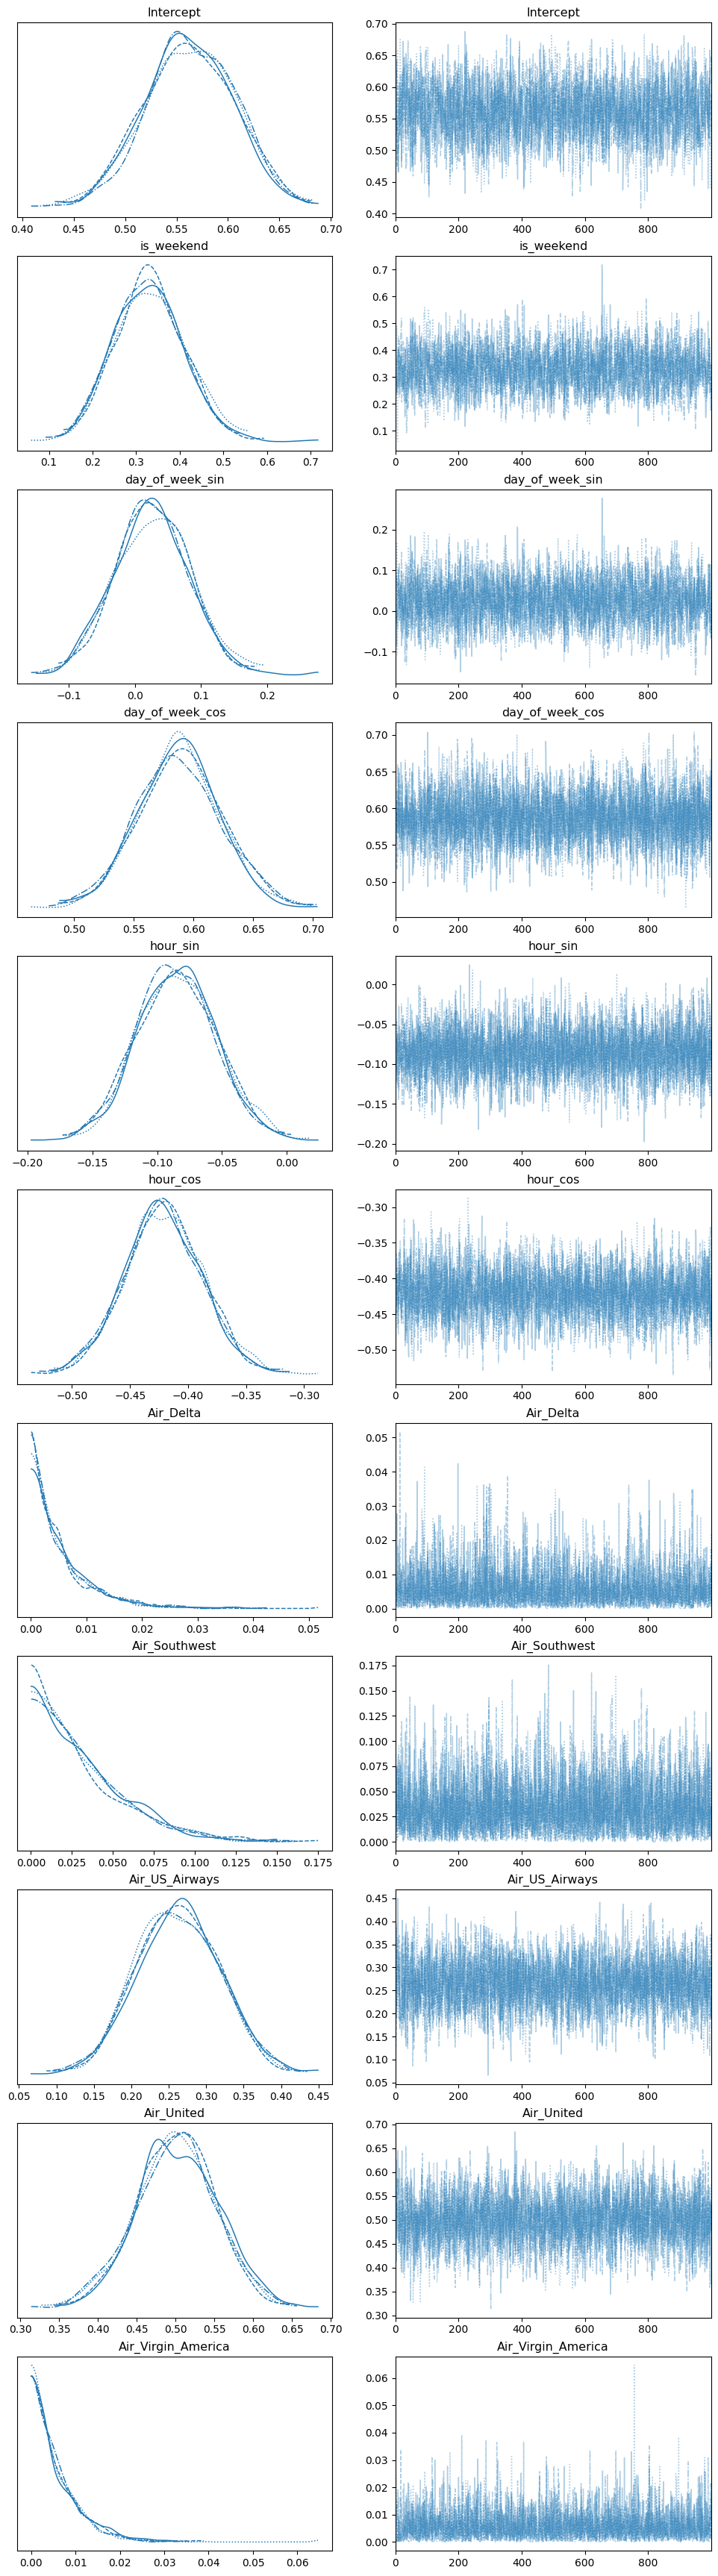

In [198]:
az.plot_trace(poisson_inference_data, figsize = (12,44))

In [197]:
az.summary(np.exp(poisson_inference_data.posterior), kind="stats")


,mean,sd,hdi_3%,hdi_97%
Intercept,1.757,0.076,1.617,1.902
is_weekend,1.395,0.112,1.195,1.606
day_of_week_sin,1.028,0.058,0.918,1.131
day_of_week_cos,1.802,0.063,1.688,1.924
hour_sin,0.919,0.028,0.865,0.972
hour_cos,0.657,0.022,0.612,0.696
Air_Delta,1.006,0.006,1.000,1.016
Air_Southwest,1.033,0.029,1.000,1.085
Air_US_Airways,1.302,0.072,1.168,1.434
Air_United,1.652,0.085,1.490,1.814


### Conclusions

The coefficients above represent 'percentage changes'. A coefficient of 1 would mean a 1-to-1 relationship with coefficient. 0 would mean no effect at all.
####### CHECK LOGIC
1. Weekends
- The is_weekend variable is 1.4 and is significant. This means that we can expect 40% increase on hourly complaints on weekends. 
- We need to hire 40% more staff on weekends
2. 